# What We Saw from Satellite-Retrieved Snow Cover Data

In this demo we are going to show snow cover data one week before Christmas eve using __[MODIS/Terra Snow Cover Daily L3 Global, Version 6](http://data.planetos.com/datasets/nsidc_modis_snow_cover_global)__ dataset. 

This dataset reports the percentage of snow-covered land in 0.05° (approx. 5 km) resolution Climate Modeling Grid (CMG) cells. Percentages are computed from snow cover observations in the MODIS/Terra Snow Cover Daily L3 Global 500m Grid (MOD10A1) dataset. Cloud cover percentages are also provided. 

We are going to use _daily snow extent_ variable and we will be looking at the Northern part of the globe, from latitude 10N to 71N. 

__[MODIS](https://modis.gsfc.nasa.gov/about/)__  (Moderate Resolution Imaging Spectroradiometer) is a key instrument aboard the Terra and Aqua satellites. Terra's orbit around the Earth is timed so that it passes from north to south across the equator in the morning, while Aqua passes south to north over the equator in the afternoon. Terra MODIS and Aqua MODIS are viewing the entire Earth's surface every 1 to 2 days, acquiring data in 36 spectral bands. 

As MODIS uses visible light from Earth, data is not collected during the night. Also, clouds are influencing the results. In this dataset there are some values that are referring to different kind of conditions. We have created a map to illustrate why there is no data collected from some of these places.

In this demo we will:

1) use the Planet OS package API to fetch data;

2) show snow cover map from one week before Christmas 2017, 2018 and 2019;

3) show map with masked value meanings.

In [56]:
%matplotlib notebook
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['font.family'] = 'Avenir Lt Std'

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [57]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

At first, we need to define the dataset name and a variable we want to use.

In [58]:
dh=datahub.datahub(server,version,API_key)
dataset='nsidc_modis_snow_cover_global'
variable_name1 = 'Day_CMG_Snow_Cover'
time_start1 = '2019-12-17T00:00:00'; time_end1 = '2019-12-17T23:00:00'

In [59]:
time_start2 = '2018-12-17T00:00:00'; time_end2 = '2018-12-17T23:00:00'

time_start3 = '2017-12-17T00:00:00'; time_end3 = '2017-12-17T23:00:00'

Then we define spatial range. At this time, we will look into Northern Hemisphere from 10N to 71N. 

In [60]:
area_name = 'north'
latitude_north = 71; longitude_west = -160
latitude_south = 10; longitude_east = 180

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

In [61]:
package1 = package_api.package_api(dh,dataset,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,time_start1,time_end1,area_name=area_name)
package2 = package_api.package_api(dh,dataset,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,time_start2,time_end2,area_name=area_name)
package3 = package_api.package_api(dh,dataset,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,time_start3,time_end3,area_name=area_name)

In [62]:
package1.make_package()
package2.make_package()
package3.make_package()

Package exists
Package exists
Package exists


In [63]:
package1.download_package()
package2.download_package()
package3.download_package()

File already downloaded
File already downloaded
File already downloaded


### Work with downloaded files

We start by opening the files with xarray and by making the data column names _masked_snow_cover_. At first, we will have the same data as _Day_CMG_Snow_Cover_, but later, we will mask out values that are explained under the _Day_CMG_Snow_Cover Key_ attribute.

In [64]:
dd1 = xr.open_dataset(package1.local_file_name)
dd1['masked_snow_cover'] = dd1.Day_CMG_Snow_Cover

dd2 = xr.open_dataset(package2.local_file_name)
dd2['masked_snow_cover'] = dd2.Day_CMG_Snow_Cover

dd3 = xr.open_dataset(package3.local_file_name)
dd3['masked_snow_cover'] = dd3.Day_CMG_Snow_Cover

Here you can see what different mask values mean. Note that, we will make a map of them at the end of this notebook

In [65]:
masks = dd1.Day_CMG_Snow_Cover.Key.split(',')
print (masks)
masks = masks[1:]

['0-100=percent of snow in cell', ' 107=lake ice', ' 111=night', ' 237=inland water', ' 239=ocean', ' 250=cloud obscured water', ' 253=data not mapped', ' 255=fill']


In [66]:
for imask,mask in enumerate(masks):
    mask_value = float(mask[:4])
    dd1['masked_snow_cover'].data = np.ma.masked_where(dd1['masked_snow_cover'].data == mask_value,dd1['masked_snow_cover'].data)
    dd2['masked_snow_cover'].data = np.ma.masked_where(dd2['masked_snow_cover'].data == mask_value,dd2['masked_snow_cover'].data)
    dd3['masked_snow_cover'].data = np.ma.masked_where(dd3['masked_snow_cover'].data == mask_value,dd3['masked_snow_cover'].data)

Now we are making Basemap of the area on what we will show the data.

In [67]:
m_demo=Basemap(projection='merc',llcrnrlat=latitude_south,urcrnrlat=latitude_north,\
            llcrnrlon=-160,urcrnrlon=longitude_east,lat_ts=(latitude_north+latitude_south)/2,resolution='l')
Dx,Dy = np.meshgrid(dd1.lon.data,dd1.lat.data)
dx,dy = m_demo(Dx,Dy)

Then it is time to plot all the data,so that we can see where the snow occured during December 16th each year. However, we will  not able to see the data from some of the locations in the North. Reasons to why are explained below.

On this map, we can see that Canada had plenty of snow week before Christmas, also some places in the North of US, mostly in the mountains. While in Europe France Alps have the most snow. Andorra seems to have persistent snow cover in mountains as well. Also Norway and Sweden have some snow. Unfortunately we can't see data from Lapland, which definately have a lot snow, because of the polar night. We can see that many Europe countries don't have persistent snow cover, but some parts still have a little snow. The eastern part of the world also have snow, especially Russia, Kazakhstan, Mongolia and China.

If you want to have closer look, you can use tools below the map to zoom in. We definitely encourage you to try that.

<IPython.core.display.Javascript object>


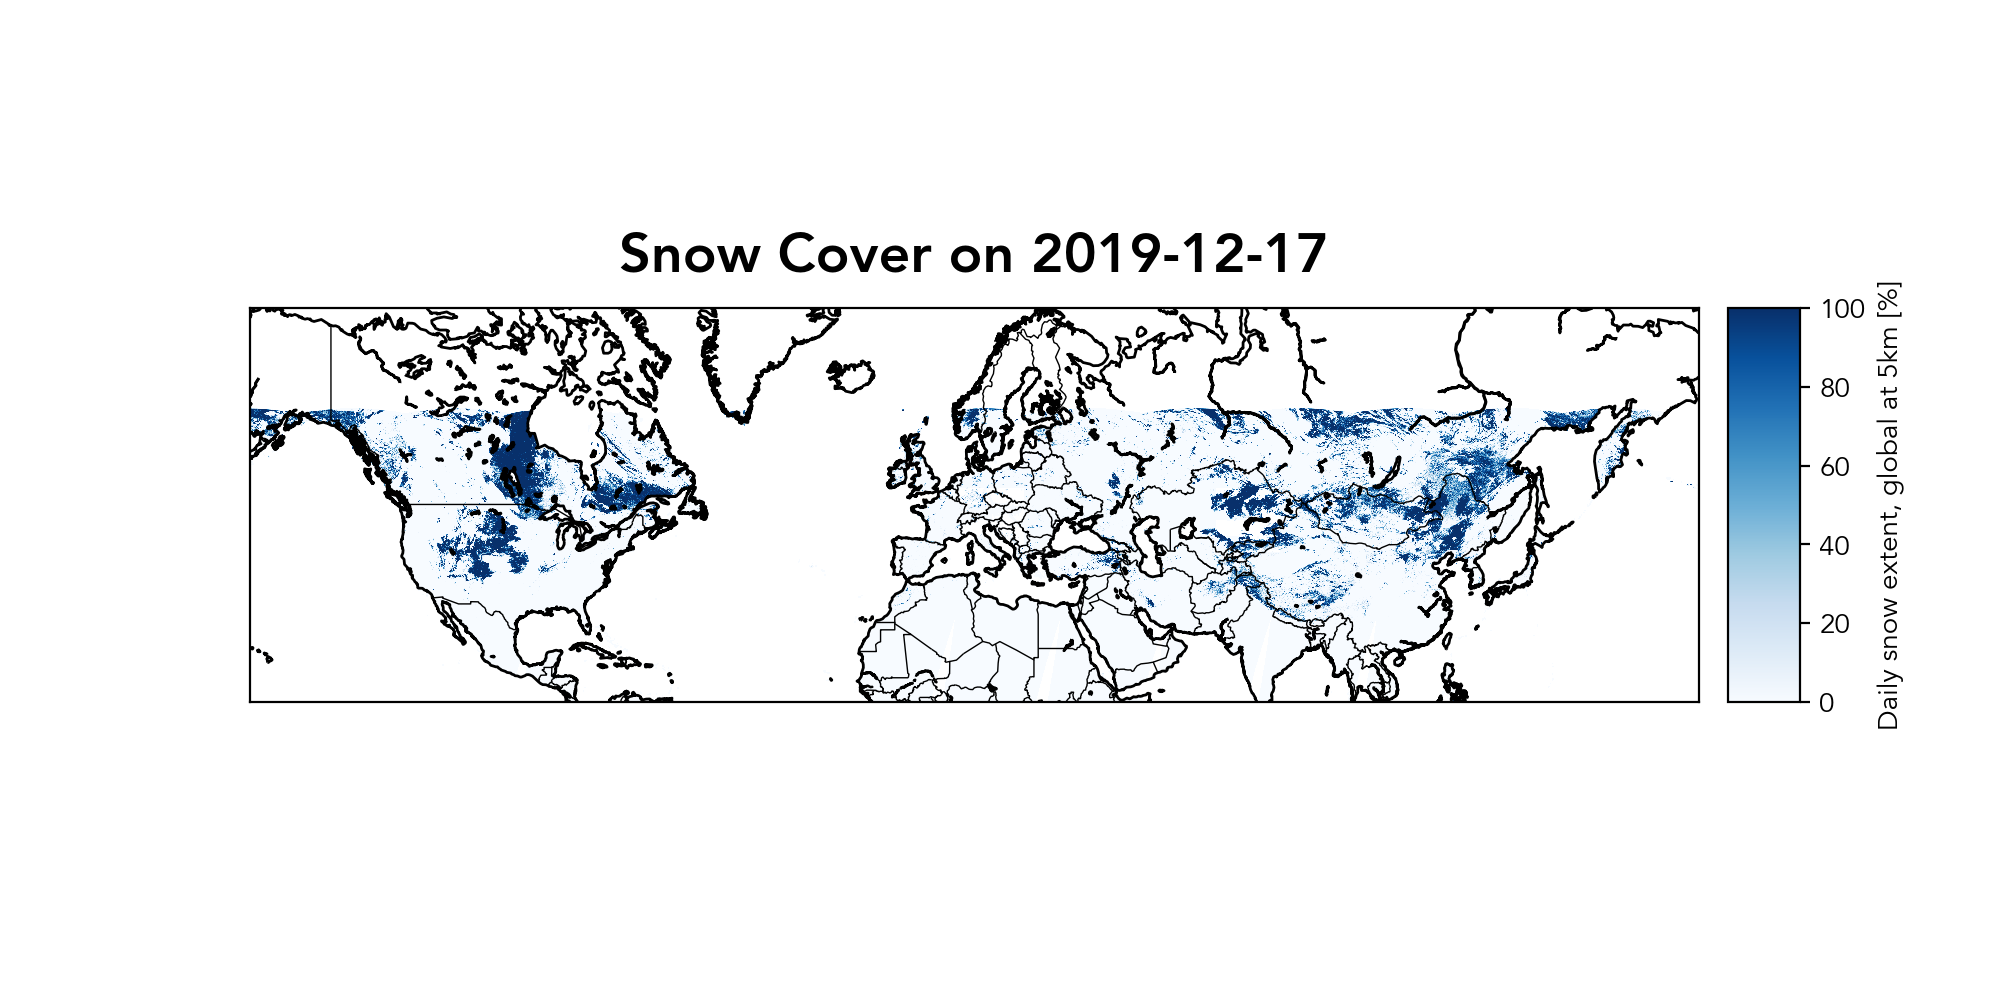

In [68]:
fig=plt.figure(figsize=(10,5))
mp = m_demo.pcolormesh(dx,dy,dd1['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo.colorbar(mp,label = dd1.Day_CMG_Snow_Cover.long_name + '[' + dd1.Day_CMG_Snow_Cover.units + ']')
ttl = plt.title('Snow Cover on ' + str(dd1.time.values[0])[:-19],fontsize=20,fontweight = 'bold')
ttl.set_position([.5, 1.05])
m_demo.drawcoastlines()
m_demo.drawcountries()

For comparisson, we add data from 2017 and 2018 to find out what has changed. 

Of course, everyone can compare their region specifically by themselves and we really apperciate if you let us know what's going on there. But we are looking into some larger areas here.

In Canada, snow extent in most of the areas seems to be wider as in previous years. As for the US overall, there is some snow in the mountainous regions and seems to have it even more than previous years

Europe tends to be quite snowless in the middle of December. It has snow in the Alps and other mountains, as well as some in Norway and Sweden, but not much. As an Estonian, I can say that last year, we got some snow on 17th of December. As for this year, Christmas is forecasted to be quite warm, so likely no snowy-white Christmas for the majority of the EU.

Western Russia doesn't have any snow this year as well. While in 2018 it had plenty, however, 2017 was similar to this year. In Central Russia, 2017 had quite nice snow cover, however, we have yet to see another snow cover in the area like that.

<IPython.core.display.Javascript object>


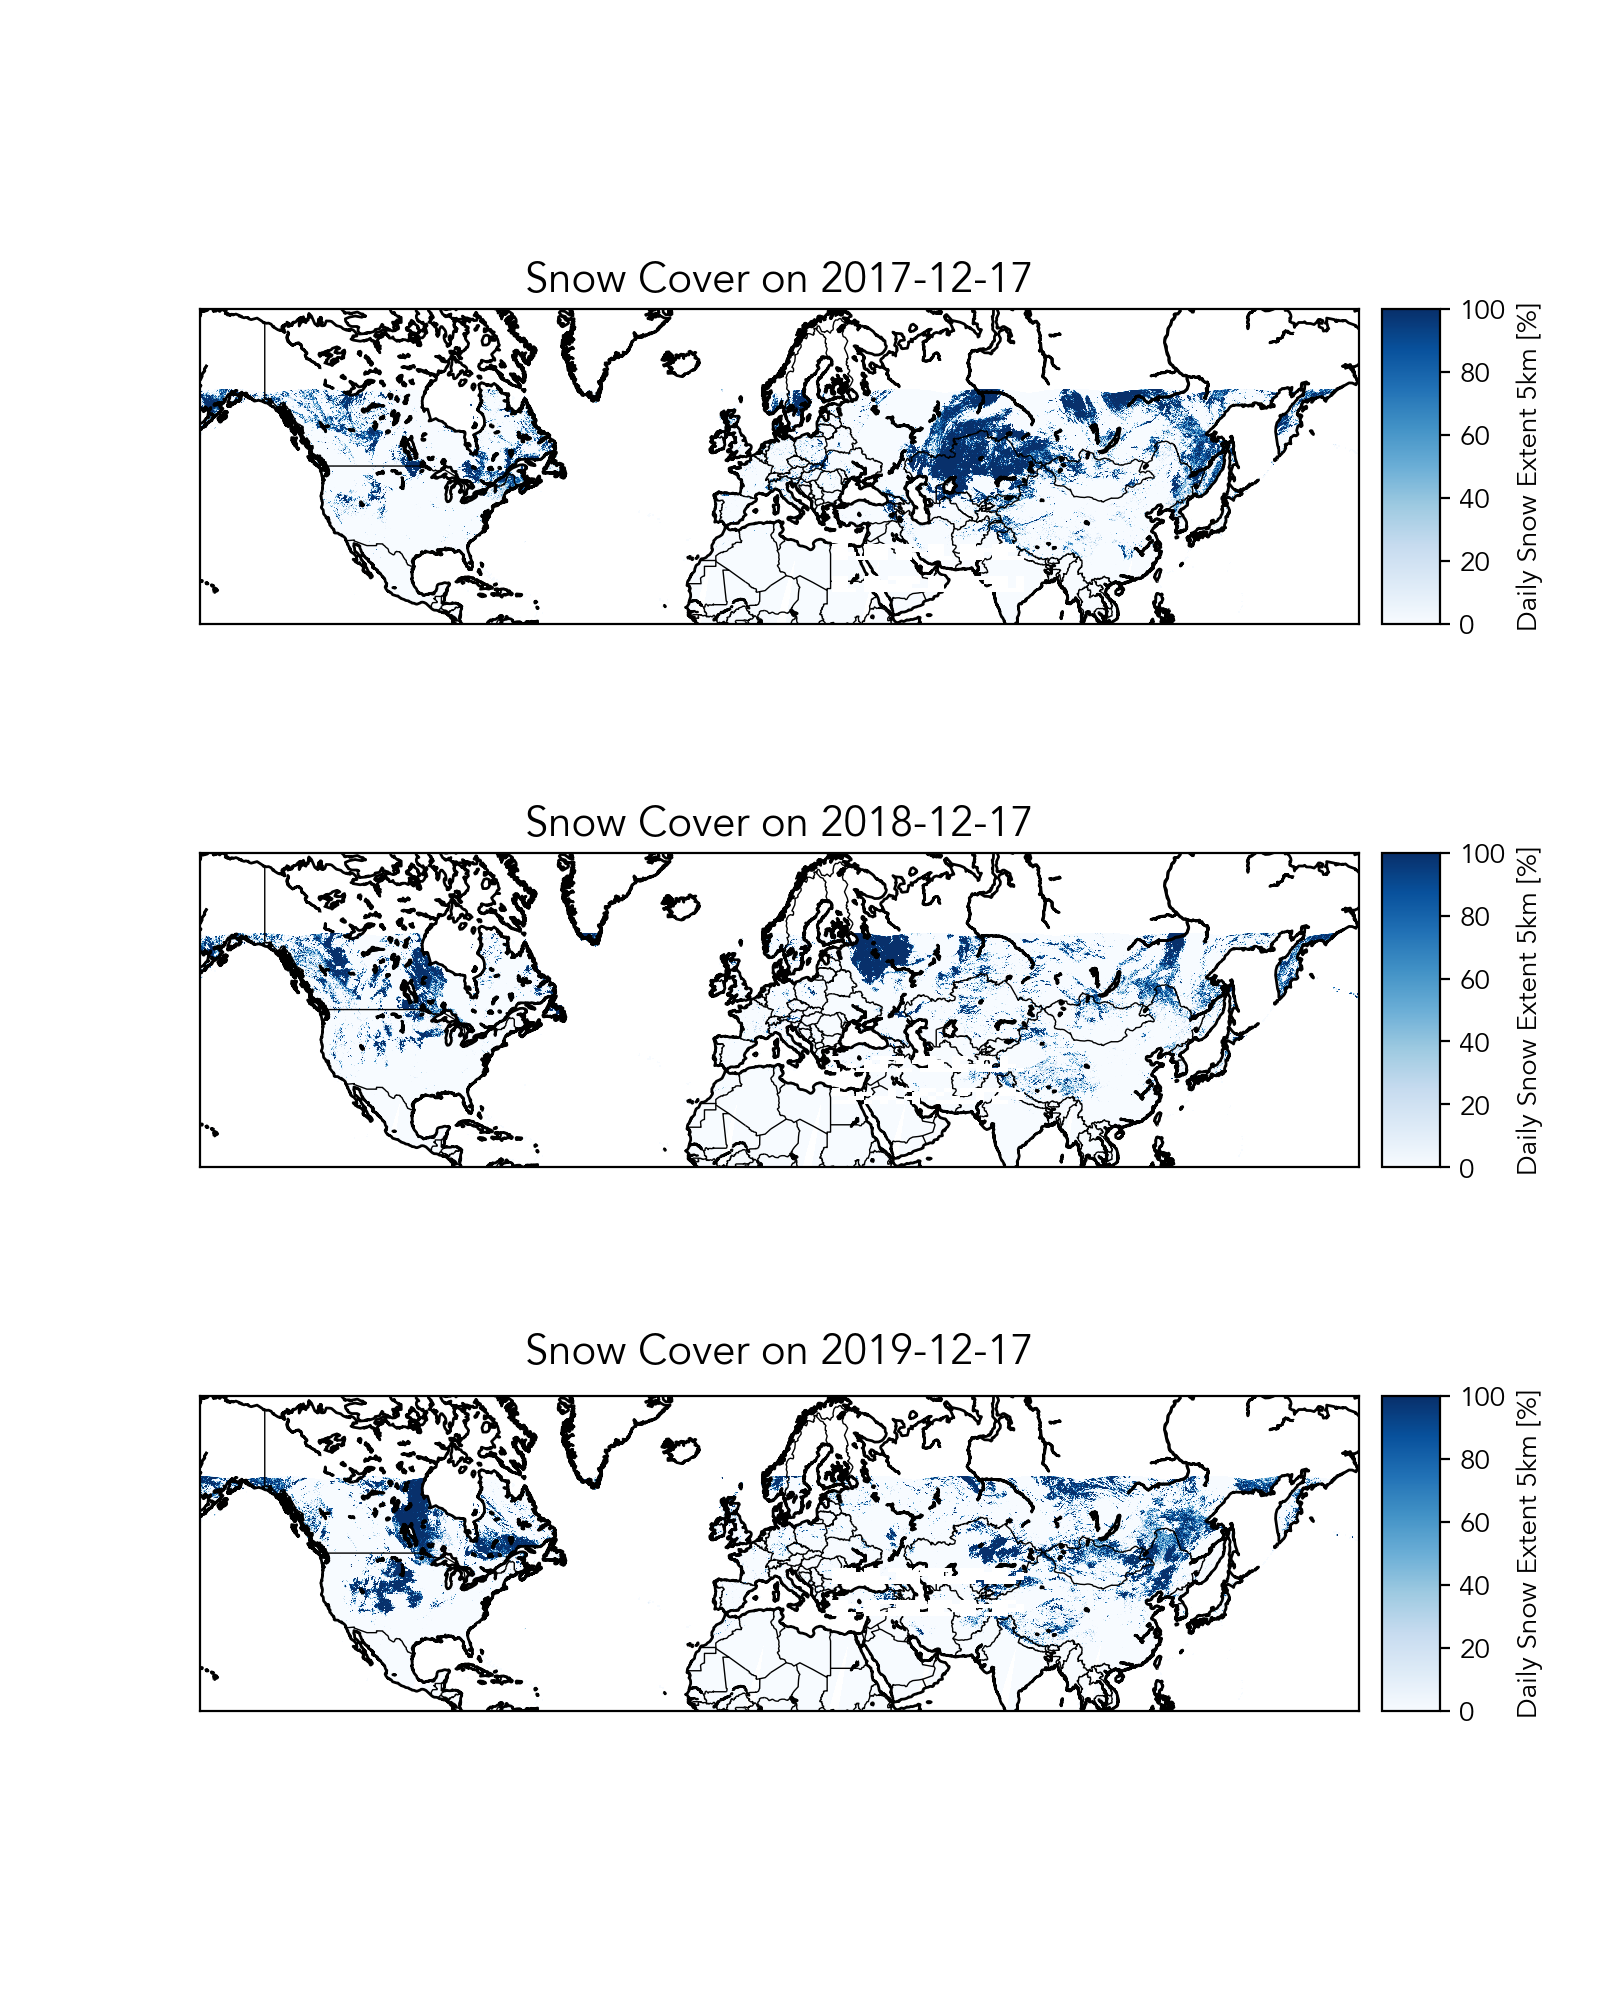

In [69]:
fig=plt.figure(figsize=(8,10))

plt.subplot(313)
mp = m_demo.pcolormesh(dx,dy,dd1['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo.colorbar(mp,label = 'Daily Snow Extent 5km [%]')
ttl = plt.title('Snow Cover on ' + str(dd1.time.values[0])[:-19],fontsize=15)
ttl.set_position([.5, 1.05])
m_demo.drawcoastlines()
m_demo.drawcountries()

plt.subplot(312)
mp2 = m_demo.pcolormesh(dx,dy,dd2['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo.colorbar(mp2,label = 'Daily Snow Extent 5km [%]')
ttl = plt.title('Snow Cover on ' + str(dd2.time.values[0])[:-19],fontsize=15)
m_demo.drawcoastlines()
m_demo.drawcountries()

plt.subplot(311)
mp3 = m_demo.pcolormesh(dx,dy,dd3['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo.colorbar(mp3,label = 'Daily Snow Extent 5km [%]')
plt.title('Snow Cover on ' + str(dd3.time.values[0])[:-19],fontsize=15)
m_demo.drawcoastlines()
m_demo.drawcountries()
plt.savefig('winter_2017_18_19.png',bbox_inches='tight', dpi=300)

In [70]:
m_demo2=Basemap(projection='merc',llcrnrlat=43,urcrnrlat=49,\
            llcrnrlon=5.8,urcrnrlon=15.1,lat_ts=(43+49)/2,resolution='l')
Dx2,Dy2 = np.meshgrid(dd1.lon.data,dd1.lat.data)
dx2,dy2 = m_demo2(Dx2,Dy2)

We also wanted to compare Alps snow cover one week prior Christmas with last years as the Europe's biggest ski resorts are there. We can see that there is obviously less snow cover this year compared to 2017 and 2018. However, when we looked into 15th of December, results were totally different. There's definitely a snow cover in higher elevations, but some snow has melted in lower places. [Weather to Ski](https://www.weathertoski.co.uk/weather-snow/) gives nice daily updates about weather conditions in Alps. 17th Dec update says: "The weather in the Alps continues to be dominated by a mild southerly airflow, bringing cloud and some precipitation to the southern side of the Alps (especially in the western Italian Alps), but brighter, “Foehny” conditions (warm gusty wind) in the north, which is melting a lot of their lower-lying snow.". That has going on for some days now and could be a reason why results has changed so drastically. 

<IPython.core.display.Javascript object>


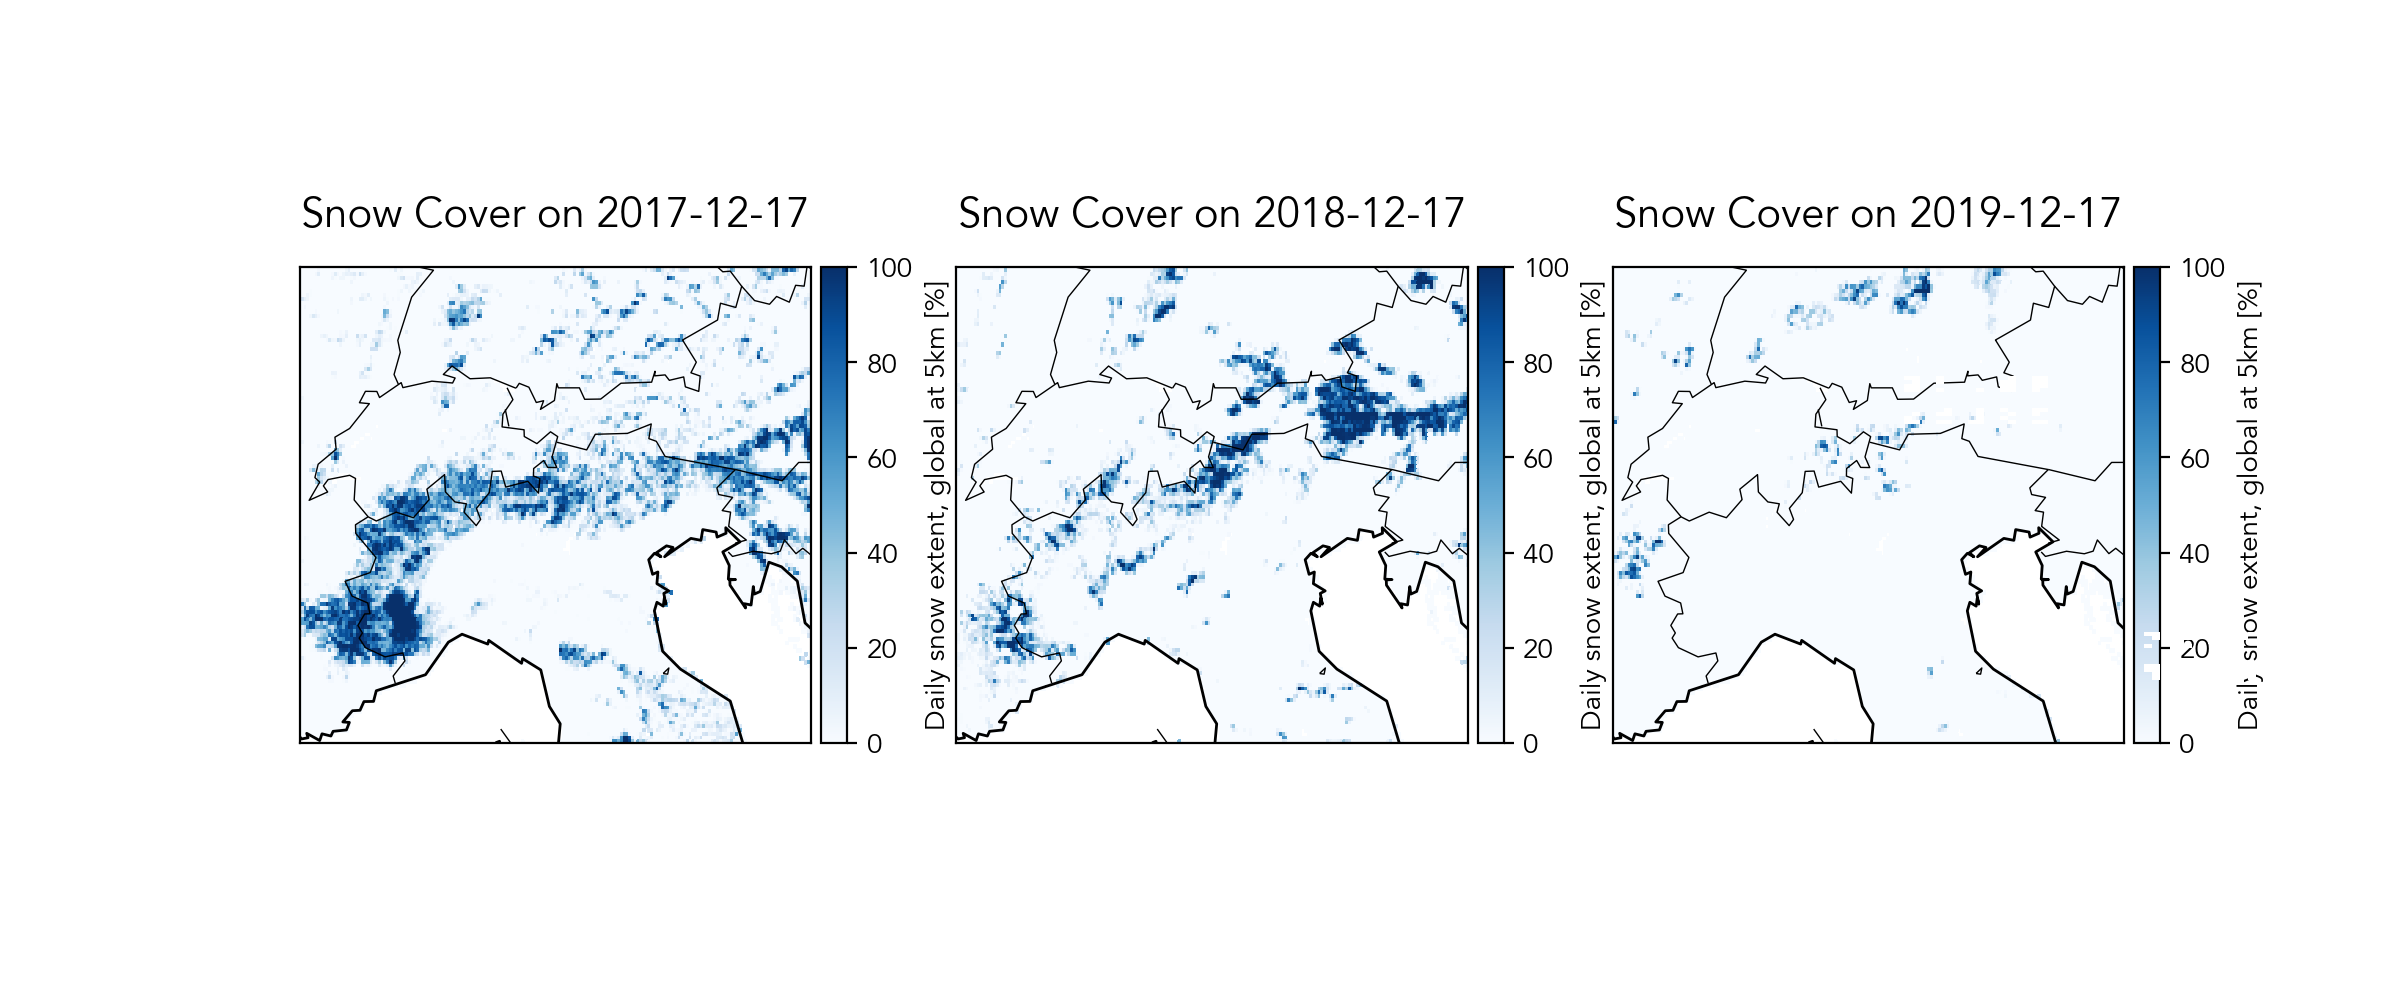

In [71]:
fig=plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(133)
mp = m_demo2.pcolormesh(dx2,dy2,dd1['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo2.colorbar(mp,label = dd1.Day_CMG_Snow_Cover.long_name + '[' + dd1.Day_CMG_Snow_Cover.units + ']')
ttl = plt.title('Snow Cover on ' + str(dd1.time.values[0])[:-19],fontsize=15)
ttl.set_position([.5, 1.05])
m_demo2.drawcoastlines()
m_demo2.drawcountries()

ax2 = fig.add_subplot(132)
mp = m_demo2.pcolormesh(dx2,dy2,dd2['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo2.colorbar(mp,label = dd2.Day_CMG_Snow_Cover.long_name + '[' + dd2.Day_CMG_Snow_Cover.units + ']')
ttl = plt.title('Snow Cover on ' + str(dd2.time.values[0])[:-19],fontsize=15)
ttl.set_position([.5, 1.05])
m_demo2.drawcoastlines()
m_demo2.drawcountries()

ax3 = fig.add_subplot(131)
mp = m_demo2.pcolormesh(dx2,dy2,dd3['masked_snow_cover'].data[0,:,:],vmin=0,vmax=100,cmap = 'Blues')
m_demo2.colorbar(mp,label = dd3.Day_CMG_Snow_Cover.long_name + '[' + dd3.Day_CMG_Snow_Cover.units + ']')
ttl = plt.title('Snow Cover on ' + str(dd3.time.values[0])[:-19],fontsize=15)
ttl.set_position([.5, 1.05])
m_demo2.drawcoastlines()
m_demo2.drawcountries()

plt.savefig('winter_alps2019.png',bbox_inches='tight')

As we briefly explained above we couldn't show data for some of the places. We will now create a map that highlights these places. For doing that we need to get rid off the real values and also make _fill values_ back to 255 as they occur as the NaN at the moment.

In [72]:
masked_values = dd1.Day_CMG_Snow_Cover.data[0,:,:]
masked_values = np.ma.masked_where(masked_values < 101,masked_values)
masked_values[np.isnan(masked_values)] = 255

On the new map below we can see that in some of the northern parts there is no data because MODIS instrument requires sunlight to operate (it's like a digital camera in many respects). During Christmas time most of that region has a polar night or very little daylight. Therefore, the data about snow can't be shown. In some places between 10N to 29N latitude, the data wasn't mapped, because those areas were out of the __[sensor range](https://sos.noaa.gov/ftp_mirror/rt/modis/media/thumbnail_big.jpg)__ .

<IPython.core.display.Javascript object>


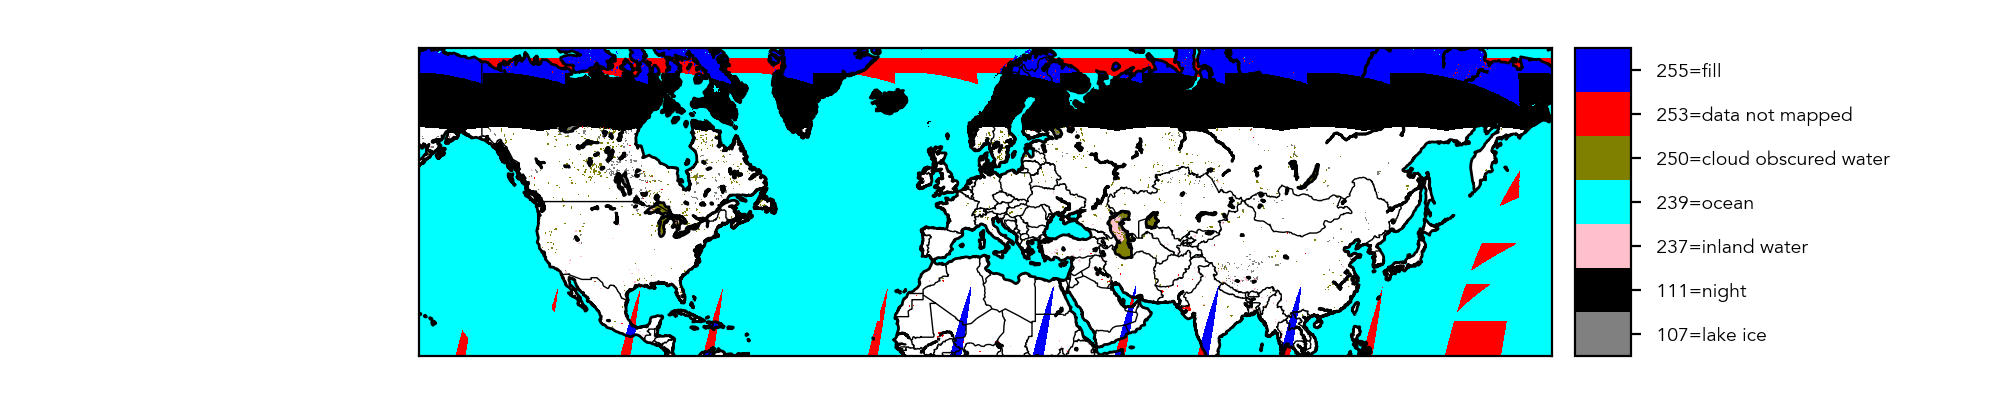

In [73]:
#107=lake ice', ' 111=night', ' 237=inland water', ' 239=ocean', ' 250=cloud obscured water', ' 253=data not mapped', ' 255=fill'
fig=plt.figure(figsize=(10,2))
cmap = colors.ListedColormap(['grey','black','pink','cyan','olive','red','blue'])
bounds = [106,108,112,238,240,251,254,256]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
d = m_demo.pcolormesh(dx,dy,masked_values,cmap=cmap, norm=norm)
cbar = m_demo.colorbar(d,ticks=[107,110,175,239,245.5,252.5,255])
cbar.ax.tick_params(labelsize=7) 
cbar.ax.set_yticklabels(masks) 
m_demo.drawcoastlines()
m_demo.drawcountries()
plt.show()